In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings("ignore")

# Import adfuller
from statsmodels.tsa.stattools import adfuller

# For statistical analysis
from statsmodels.tsa.arima_model import ARIMA

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.dates as mdates

import yfinance as yf

In [2]:
df = yf.download( "BAC", start = "2020-01-01", end = "2020-12-31")[['Adj Close']]
df.head()

[*********************100%***********************]  1 of 1 completed


,Adj Close
Date,
2020-01-02,34.709141
2020-01-03,33.988472
2020-01-06,33.939774
2020-01-07,33.715782
2020-01-08,34.056641


In [3]:
null_values = int( df.isnull().sum() )

print(f"There are {null_values} missing values on NFLX asset" )

There are 0 missing values on NFLX asset


In [4]:
def check_for_stationarity(df, name):
    adf_test = adfuller(df)
    
    if ( adf_test[1] < 0.05 ):
        print(f"The time series for {name} is stationary")
    else:
        print(f"The time series for {name} is Not stationary")

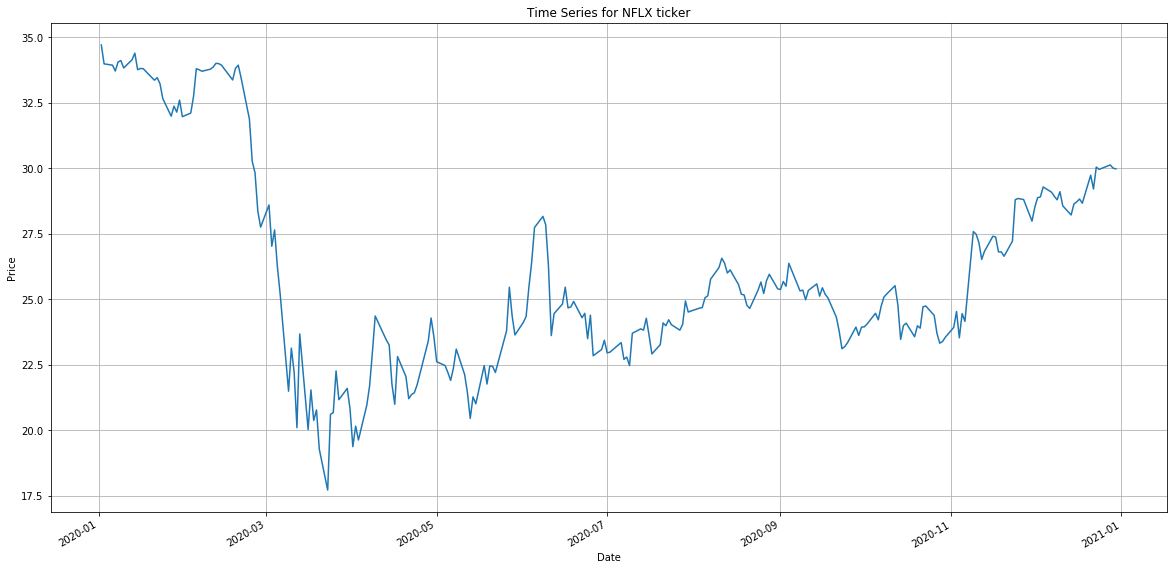

In [5]:
df['Adj Close'].plot(figsize = (20,10), grid = True, title = "Time Series for NFLX ticker") 
plt.ylabel("Price")
plt.xlabel("Date")
plt.show()

In [6]:
check_for_stationarity(df, 'NFLX')

The time series for NFLX is Not stationary


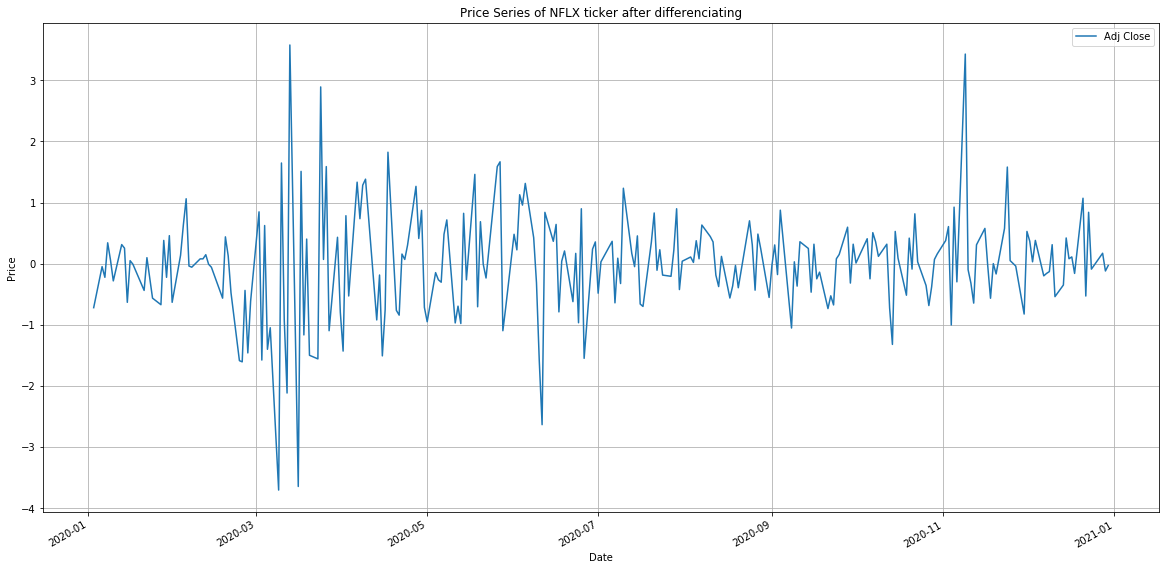

In [7]:
df.diff().dropna().plot( figsize = (20,10), grid = True, title = "Price Series of NFLX ticker after differenciating" ) 
plt.ylabel("Price")
plt.xlabel( "Date" )
plt.show()

In [8]:
check_for_stationarity( df.diff().dropna(), "NFLX_diff"  )

The time series for NFLX_diff is stationary


Since it required only one differenciation to make the time series stationarity. We can use order of I of one. Meaning that for our ARIMA model will have ARIMA(p,1,q) where 1 is the order of the integrated term. 

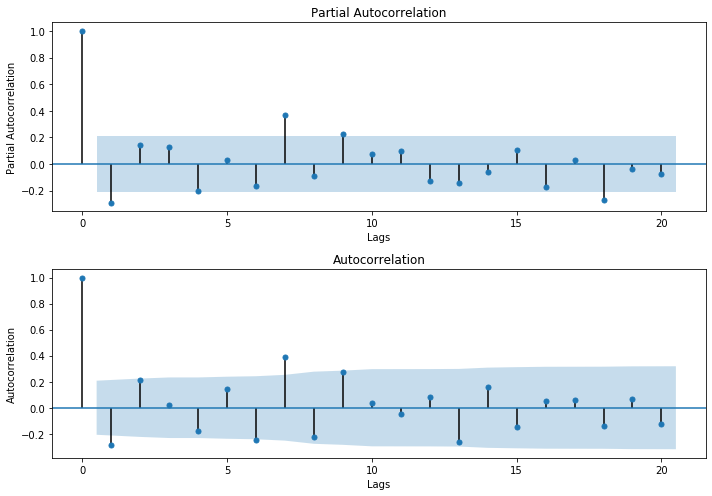

In [9]:
# Find the order of AR and MA
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7))

rolling_window = 90    # we had 16 hours of hourly tick data for each day.
# Plot Partial Autocorrelation Function
plot_pacf(df['Adj Close'][:rolling_window].diff().dropna(), lags=20, ax=ax1)
ax1.set_xlabel('Lags')
ax1.set_ylabel('Partial Autocorrelation')

# Plot Autocorrelation Function
plot_acf(df['Adj Close'][:rolling_window].diff().dropna(), lags=20, ax=ax2)
ax2.set_xlabel('Lags')
ax2.set_ylabel('Autocorrelation')

plt.tight_layout()
plt.show()

From the above we can see that the after the fourth lag, the rest of the lags are statistically insignificant for both the ACF and PACF. Therefore, a good ARIMA model could be ARIMA( p=4, d = 1, q = 4 )

### Model ARIMA(4,1, 4) 

In [10]:
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)

# Fit ARIMA model
model = ARIMA(df['Adj Close'][:rolling_window], order=(1, 1, 1))
model_fit_0 = model.fit()
print(model_fit_0.params.round(2))

const               -0.14
ar.L1.D.Adj Close   -0.48
ma.L1.D.Adj Close    0.20
dtype: float64


From the output above, we can see that the model becomes
$$ ARIMA(4,1,4) = y_t = -0.04 - 0.02y'_{t-1} - 0.23y'_{t-2} + 0.17y'_{t-3} + 0.02\epsilon_{t-1} + 0.19\epsilon_{t-2} - 0.30\epsilon_{t-3} + \epsilon_t$$

### Forecast the time series

In [11]:
# Function to predict the price of 1 day
def predict_price_ARIMA(train_data):
    # Define model
    model = ARIMA(train_data, order=(1, 1, 1))
    # Fit the model
    try:
        model_fit = model.fit(disp=0, start_params=model_fit_0.params)
        # Make forecast
        return model_fit.forecast()[0][0]
    except:
        pass

In [12]:
# Predict the price using `predict_price_ARIMA` function
df['predicted_price'] = df['Adj Close'].rolling(rolling_window).apply(predict_price_ARIMA)

# Shift the predicted price by 1 period
df['predicted_price'] = df['predicted_price'].shift(1)

<a id='evaluate'></a> 
## Evaluate model performance

You can check the performance of the model by calculating the error metric and residual analysis.

In [13]:
# Import libraries
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt

def model_performance(observed, predicted):
    """This function will print the Mean Absolute Error, Mean Squared Error,
    Root Mean Squared Error and Mean Absolute Percentage Error.
    This function will also display the residula plot and the ACF.
    """
    # Mean Absolute Error
    mae = mean_absolute_error(observed, predicted)
    print('The Mean Absolute Error is %.2f' % mae)

    # Mean Squared Error
    mse = mean_squared_error(observed, predicted)
    print('The Mean Squared Error is %.2f' % mse)

    # Root Mean Squared Error
    rmse = sqrt(mean_squared_error(observed, predicted))
    print('The Root Mean Squared Error is %.2f' % rmse)

    # Mean Absolute Percentage Error
    mape = 100 * ((observed-predicted)/observed).abs().mean()
    print('The Mean Absolute Percentage Error is %.2f' % mape)

    # Residuals
    residuals = observed - predicted
    labels = observed.index
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 11))
    
    # Plot residual
    observed.plot(ax=ax1, color='purple')
    predicted.plot(ax=ax1, color='green')
    ax1.set_ylabel('Price')
    ax1.set_title('Predicted Vs. Observed')
    
    # Plot residual
    ax2.fill_between(residuals.index, residuals.values, color='red')
    ax2.set_ylabel('Error')
    ax2.set_xlabel('Date')
    ax2.set_title('Residual')
    ax2.set_xticklabels(labels, rotation=45, ha='right')
    ax2.xaxis.set_major_formatter(mdates.DateFormatter("%d-%m-%Y"))
    ax2.xaxis.set_minor_formatter(mdates.DateFormatter("%d-%m-%Y"))
    _=plt.xticks(rotation=45)
    
    # Autocorrelation plot of residuals
    plot_acf(residuals, ax=ax3, color='blue')
    ax3.set_xlabel('Lags')
    ax3.set_ylabel('Autocorrelation')
    ax3.set_title('Autocorrelation of Residuals')

    plt.tight_layout()
    plt.show()

The Mean Absolute Error is 0.50
The Mean Squared Error is 0.49
The Root Mean Squared Error is 0.70
The Mean Absolute Percentage Error is 1.98


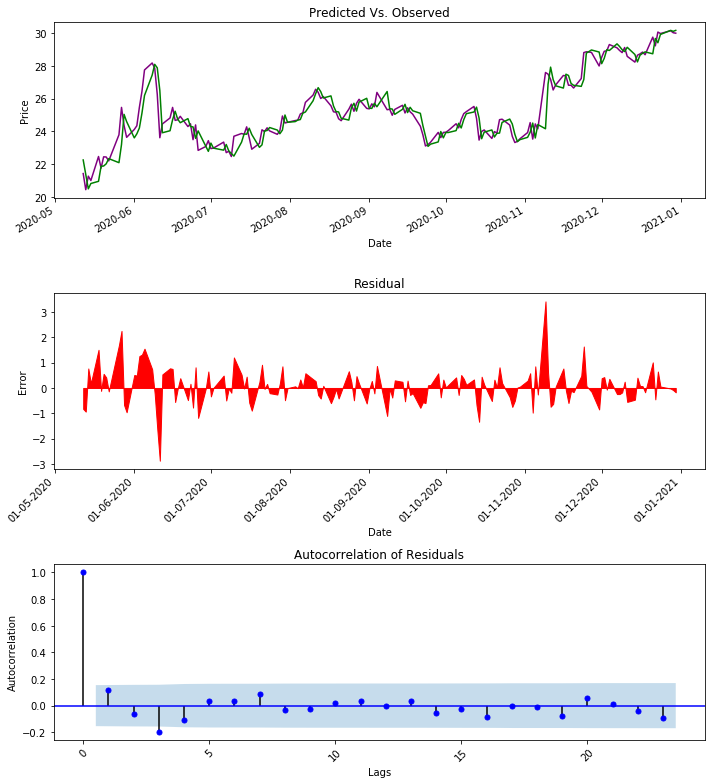

In [14]:
model_performance(df['Adj Close'].iloc[rolling_window:],
                  df['predicted_price'].iloc[rolling_window:])

## Analyze the Strategy Performance

In [15]:
# Create signal
df['signal'] = np.where(df.predicted_price.shift(1) <
                          df.predicted_price, 1, 0)

df['returns'] = df['Adj Close'].pct_change()

df['strategy_returns'] = df.signal.shift(
    1) * df.iloc[rolling_window:].returns

In [16]:
def analyse_strategy(strategy_returns):    
    
    sharpe_ratio = strategy_returns.mean() / strategy_returns.std() * np.sqrt(252)

    # Cumulative Returns
    cumulative_returns = (strategy_returns+1).cumprod()
    
    # ---------- Drawdown calculations -------------------
    # Calculate the running maximum
    running_max = np.maximum.accumulate(cumulative_returns.dropna())
    # Ensure the value never drops below 1
    running_max[running_max < 1] = 1
    # Calculate the percentage drawdown
    drawdown = 100*((cumulative_returns)/running_max - 1)

    # Calculate the maximum drawdown
    max_dd = drawdown.min()

    # Print the statistics
    print('The Sharpe Ratio is %.2f' % sharpe_ratio)
    print('The cumulative return is %.2f' % (
      ((cumulative_returns[-1])-1)*100) + "%") 
    print("The maximum drawdown is %.2f" % max_dd + "%")

    # Plot
    labels = strategy_returns.index
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7))

    # Plot strategy returns
    ax1.plot(cumulative_returns, color='b')
    ax1.set_title('Cumulative Returns', fontsize=14)
    ax1.set_ylabel('Cumulative Returns', fontsize=12)
    ax1.set_xlabel('Date', fontsize=12)
    ax1.set_xticklabels(labels, rotation=45, ha='right')
    ax1.xaxis.set_major_formatter(mdates.DateFormatter("%d-%m-%Y"))
    ax1.xaxis.set_minor_formatter(mdates.DateFormatter("%d-%m-%Y"))
   
    # Plot max DD
    ax2.plot(drawdown, color='red')
    # Fill in-between the drawdown
    ax2.fill_between(drawdown.index, drawdown.values, color='red')
    ax2.set_title('Strategy Drawdown', fontsize=14)
    ax2.set_ylabel('Drawdown (%)', fontsize=12)
    ax2.set_xlabel('Date', fontsize=12)
    ax2.set_xticklabels(labels, rotation=45, ha='right')
    ax2.xaxis.set_major_formatter(mdates.DateFormatter("%d-%m-%Y"))
    ax2.xaxis.set_minor_formatter(mdates.DateFormatter("%d-%m-%Y"))

    plt.tight_layout()
    plt.show()
    

The Sharpe Ratio is 1.43
The cumulative return is 30.86%
The maximum drawdown is -9.99%


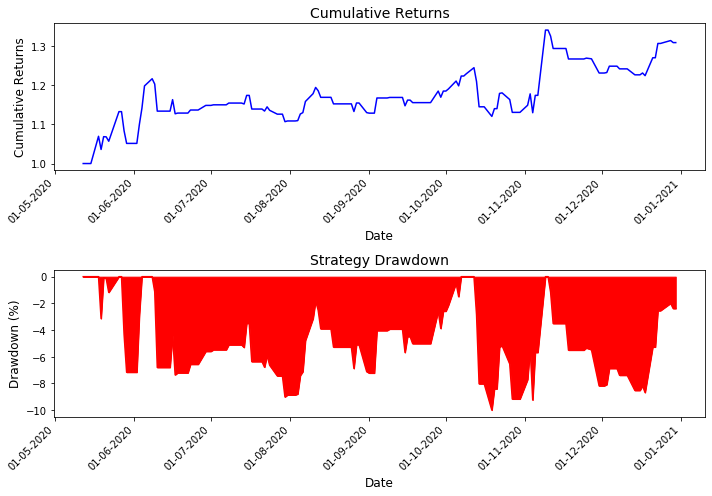

In [17]:
analyse_strategy(df['strategy_returns'].iloc[rolling_window:]) 

Start date,2020-01-02
End date,2020-12-30
Total months,12
,Backtest
Annual return,30.9%
Cumulative returns,30.9%
Annual volatility,33.0%
Sharpe ratio,1.43
Calmar ratio,3.09
Stability,0.61
Max drawdown,-10.0%


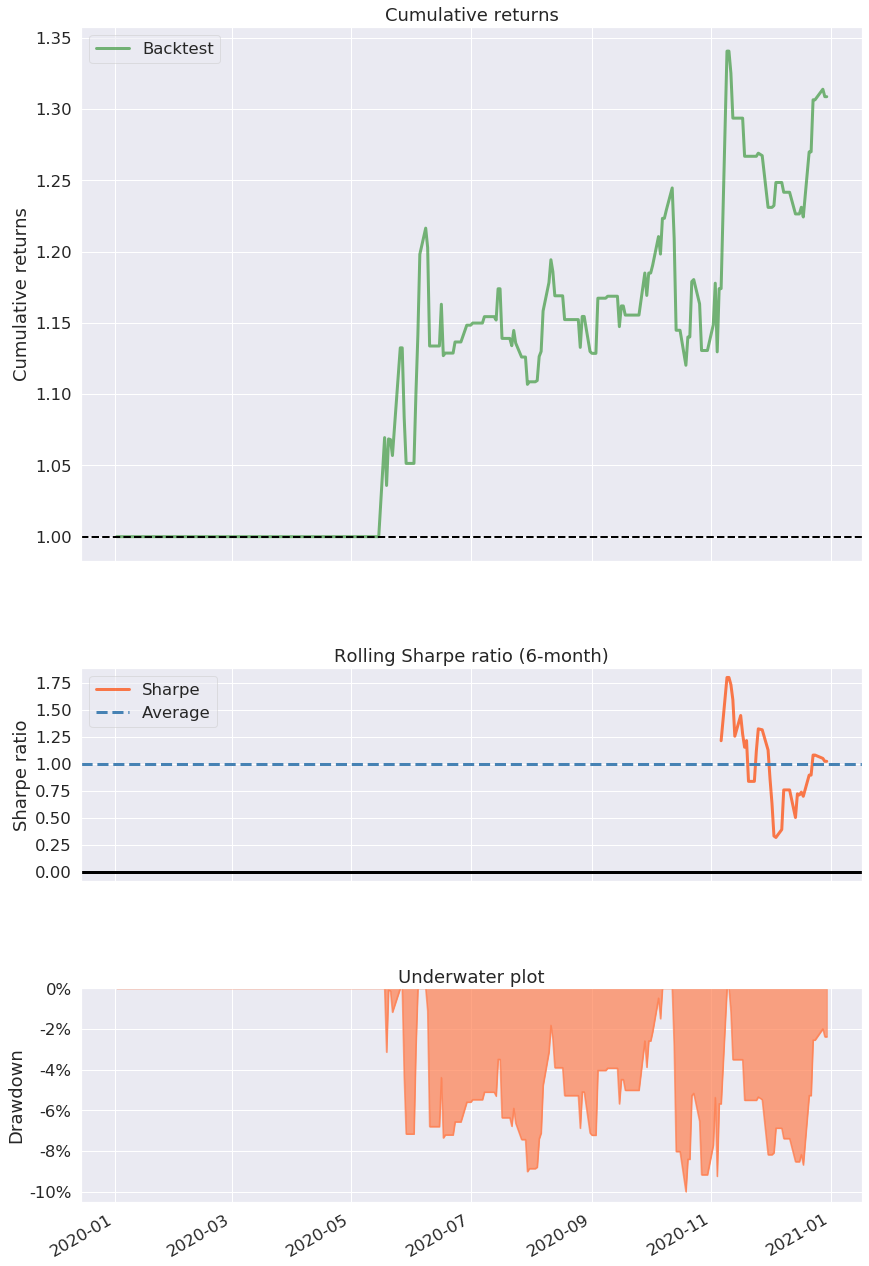

In [19]:
# Analyse results with pyfolio by passing the daily returns
import pyfolio as pf
pf.create_simple_tear_sheet( df['strategy_returns']) 